Firstly, connect to both the LSPone and the NI DAQ.

In [ ]:
import pandas as pd
import numpy as np
import time
from Spectrometer_analysis import *
import threading
import os

In [2]:
# Setup your hardware
daq = NIDAQ(device_name="Dev2", channel="ai0")
LSPone = AMF("COM5")  # Update COM port if needed

# Optional: Prepare the pump
LSPone.send_command('Z3')  # Low force home
LSPone.wait_until_free()
LSPone.send_command('V200')  # Set peak speed
LSPone.wait_until_free()

Sending command: /1Z3R
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1V200R
Sending command: /1?6
Sending command: /1?6


### Once the LSPone has been initialized for the day, perform priming of all the tubes that will be used and wash the chip. all tubes - LSPone.prime_tubes(list(range(1, 13)))

In [ ]:
LSPone.prime_tubes(list(range(1, 13)))

### Priming individual tubes

In [3]:
LSPone.prime_tubes([3, 4])

Priming tube 3 with command: B3V200P2000R
Sending command: /1B3V200P2000RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1B11V200A0RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Priming tube 4 with command: B4V200P2000R
Sending command: /1B4V200P2000RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1B11V200A0RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6


### Testing the light pulsing
1. Set the Laser controler to 'mod'
2. Run the cell below and observe the light pulsing

In [2]:
daq = NIDAQ(device_name="Dev2", channel="ai0")


In [7]:
stop_event.clear()

In [4]:
daq.turn_lamp_on()

Lamp turned ON.


In [5]:
daq.turn_lamp_off()

Lamp turned OFF.


In [15]:
stop_event.clear()
pulse_thread = threading.Thread(target=daq.pulse_lamp)
pulse_thread.start()

Lamp pulsing stopped.


In [16]:
stop_event.set()
pulse_thread.join()

In [6]:
stop_event.clear()

In [3]:
from datetime import datetime
import os

# Create a dated folder
current_date = datetime.now().strftime("%Y-%m-%d")
folder = f"Calibration_{current_date}"
os.makedirs(folder, exist_ok=True)

# USER SETTINGS
stock_concentration = 0.4/180.156*1000/5*1000  # standard with manufacturer's stock concentration
#stock_concentration = 0.49528/198.17*1000/5*1000  # µM in-house stock concentration
print(f"Stock concentration: {stock_concentration} µM")
dilution_percentages = [0, 100]  # percent of stock to use
max_A_stock = 1000  # corresponds to 100% of stock
max_A_water = 1000  # fixed absolute position of water syringe
num_repeats = 1  # Number of times to repeat each concentration

# Calculate all dilution steps
concentrations = [round(stock_concentration * (p / 100), 2) for p in dilution_percentages] #Calculate concentrations from percentages
print(f"Concentrations: {concentrations} µM")


dilution_commands = LSPone.generate_dilution_commands(concentrations, stock_concentration, max_A_stock=max_A_stock, max_A_water=max_A_water)

# Debug output (optional)
print("\nDilution plan:")
for conc in concentrations:
    print(f"{conc} µM → {dilution_commands[conc]}")

for repeat in range(num_repeats):
    print(f"\n--- Starting Calibration Round {repeat + 1}/{num_repeats} ---")
    for concentration in concentrations:
        print(f"\nPreparing concentration: {concentration} µM (round {repeat + 1}/{num_repeats})")

        print(f"\nPreparing {concentration} µM (repeat {repeat + 1})\n")
        cmd = dilution_commands[concentration]

        # Pickup enzymes
        LSPone.send_command('B3V200A1500B5A0R')
        LSPone.wait_until_free()

        LSPone.send_command(cmd)  # glucose + water
        LSPone.wait_until_free()

        # Pickup enzymes
        LSPone.send_command('B3V200A1500B5A0R')
        LSPone.wait_until_free()

        # Mix and dispense
        LSPone.send_command('B5gV350A3000M100V350A0M2000G3V350A0R')
        LSPone.wait_until_free()

        # Start wash in background
        #wash_thread = threading.Thread(target=LSPone.background_wash)
        #wash_thread.start()

        print("Waiting 3 min for reaction...")
        time.sleep(10)

        # Ensure wash is done before continuing
        #wash_thread.join() # I should measure how long one wash cycles takes.

        print("💡 Turning lamp ON for measurement...")
        daq.turn_lamp_on()
        time.sleep(2) # just to let the laser become stable before taking measurements

        # Chip injection flow rate
        chip_inj_flow_rate = 200

        # Dispense to detection
        LSPone.send_command('B5V200A3000R') # pick up the mixture from the mixing tube
        LSPone.wait_until_free()
        LSPone.send_command(f'B2V{chip_inj_flow_rate}A100B1A0R') # inject to chip

        # Perform Measurement
        df_voltage, meas_number, fig = daq.perform_peak_voltage_detection(LSPone, idle_timeout=5.0)
        time.sleep(5) # ensure that the measurement is done before turning off the lamp.

        print("🛑 Turning lamp OFF after measurement.")
        daq.turn_lamp_off()

        # Label the measurement
        df_voltage.loc[df_voltage['Measurement'] == meas_number - 1, 'Concentration [uM]'] = concentration
        display(df_voltage.tail(1))

        # Get the latest row
        last = daq.df_voltage.loc[daq.df_voltage["Measurement"] == meas_number - 1]
        conc = last["Concentration [uM]"].iloc[0] if "Concentration [uM]" in last else None
        est = last["Estimated Concentration"].iloc[0] if "Estimated Concentration" in last else None

        # Format concentration label without decimals
        if pd.notna(conc):
            conc_label = f"{int(round(conc))}uM"
        elif pd.notna(est):
            conc_label = f"{int(round(est))}uM"
        else:
            conc_label = "Unknown"

        filename = f"voltage_M{meas_number - 1}_{conc_label}.png"

        # Save the plot
        fig.write_image(os.path.join(folder, filename))
        print(f"📁 Saved: {filename}")

        # Wash between measurements
        LSPone.send_command('B5V200A1500R')
        LSPone.wait_until_free()
        LSPone.send_command('B1V200A0R')
        LSPone.wait_until_free()

Stock concentration: 444.05959279735345 µM
Concentrations: [0.0, 444.06] µM

Dilution plan:
0.0 µM → B5V200P1000B4P0B5A0R
444.06 µM → B4V200A1000B5A0R

--- Starting Calibration Round 1/1 ---

Preparing concentration: 0.0 µM (round 1/1)

Preparing 0.0 µM (repeat 1)

Sending command: /1B3V200A1500B5A0RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1B5V200P1000B4P0B5A0RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1B3V200A1500B5A0RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sen

,Measurement,Voltage,Concentration [uM],Time
0,0,0.12393,0.0,16:24:04


📁 Saved: voltage_M0_0uM.png
Sending command: /1B5V200A1500RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1B1V200A0RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6

Preparing concentration: 444.06 µM (round 1/1)

Preparing 444.06 µM (repeat 1)

Sending command: /1B3V200A1500B5A0RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1B4V200A1000B5A0RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sendin

,Measurement,Voltage,Concentration [uM],Time
1,1,0.01738,444.06,16:27:18


📁 Saved: voltage_M1_444uM.png
Sending command: /1B5V200A1500RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1B1V200A0RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6


✅ Calibration data saved to Calibration_2025-06-10\calibration_regression.json


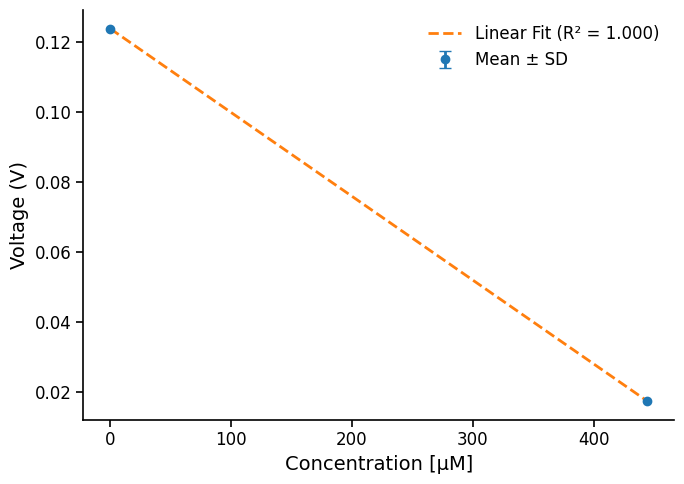

In [4]:

model, df_voltage, fig = daq.calibration_curve_ignore_blank(show_plot=False)
daq.save_calibration(os.path.join(folder, "calibration_regression.json"))
fig.savefig(os.path.join(folder, "calibration_curve.png"), format='png')
df_voltage.to_csv(os.path.join(folder, "calibration_data_raw.csv"))


no glucose from aldo, test 2.5 mM room temp

In [5]:
from types import MethodType
import threading
import time
import pandas as pd
import builtins, sys
from pathlib import Path

from datetime import datetime
import os

current_date = datetime.now().strftime("%Y-%m-%d")
folder = f"Calibration_{current_date}"
subfolder = os.path.join(folder, "Measurement")
os.makedirs(subfolder, exist_ok=True)

daq.load_calibration(os.path.join(folder, 'calibration_regression.json'))

# Override print globally to always flush
builtins.print = lambda *args, **kwargs: __import__('sys').stdout.write(' '.join(map(str, args)) + '\n') or sys.stdout.flush()

# For continuous glucose sampling
df_sample_results = pd.DataFrame(columns=['Measurement', 'Voltage', 'Estimated Concentration [uM]', 'Time'])
glucose_flow_rate = 1.5  # µL/min
stop_event = threading.Event()

def set_flow_rate(new_rate):
    global glucose_flow_rate
    glucose_flow_rate = new_rate
    print(f"✅ Flow rate updated to {glucose_flow_rate} µL/min")

def monitor_keyboard_stop():
    import sys
    print("🔁 Press 'q' then Enter at any time to stop.")
    while not stop_event.is_set():
        if input().strip().lower() == 'q':
            stop_event.set()
            print("🟥 Stop signal received. Finishing current cycle...")

def continuous_sample_estimation(self, LSPone):
    global df_sample_results
    first_cycle = True
    stored_sample_ready = False

    def sample_loop():
        nonlocal first_cycle, stored_sample_ready

        while not stop_event.is_set():
            print("\nNEW SAMPLE CYCLE STARTED")

            #rinsing

            print("🚿 Rinsing collection tube...")
            LSPone.send_command('B12V200A1300B6A0B6A3000R')
            LSPone.wait_until_free()
            
            #Start glucose collection timer (threading 1)
            wait_time = int((12.5 / glucose_flow_rate) * 60)
            print(f"Step 2: Starting glucose collection timer: {wait_time} sec")

            LSPone.send_command('B1A0R')
            LSPone.wait_until_free()

            #Push enzymes into collection microtube
            print("Step 1: Injecting 37.5 µL enzymes into collection tube...")
            LSPone.send_command('B3V200A2250B6V300A0R')
            LSPone.wait_until_free()


            glucose_wait_done = threading.Event()

            def set_and_log():
                print("⏱️ Glucose timer fired.")
                glucose_wait_done.set()

            glucose_timer = threading.Timer(wait_time, set_and_log)
            glucose_timer.start()


            if first_cycle:
                print("⏸ First cycle → waiting for glucose to arrive...")
                glucose_wait_done.wait()
                print("✅ Glucose collected. Aspirating to mixing tube...")
                LSPone.send_command('B6V200A3000B5V300A0R')
                LSPone.wait_until_free()
                stored_sample_ready = True
                first_cycle = False
                continue

            if stored_sample_ready:
                print("🔁 Step 3: Mixing sample in mixing microtube...")
                LSPone.send_command('B5gV350A3000V350A100M2000G2V350A0R')
                LSPone.wait_until_free()
                # Start 3-minute reaction timer in background
                reaction_done = threading.Event()
                threading.Timer(180, reaction_done.set).start()

                # Wash now
                print("🧼 Washing detection chip...")
                for _ in range(3):
                    LSPone.send_command('B12V200A3000B2A100R')
                    LSPone.wait_until_free()

                LSPone.send_command('B1V200A0R')
                LSPone.wait_until_free()

                # Later in the loop, wait for reaction to finish:
                print("⏳ Waiting for 3-minute reaction to complete...")
                reaction_done.wait()

                print("📤 Step 5: Injecting into detection chip...")
                LSPone.send_command('B5V200A3000R')
                LSPone.wait_until_free()
                LSPone.send_command('B2V200A100R')


                daq.turn_lamp_on()
                time.sleep(2)  # Allow lamp to stabilize
                print("📈 Step 6: Measuring and estimating...")
                df_voltage, meas_number, fig = self.perform_peak_voltage_detection(LSPone)
                print("🔢 Estimating concentration...")

                daq.turn_lamp_off()
                time.sleep(2)
                
                # Create a new DataFrame with estimated concentration (without touching self.df_voltage)
                df_estimated = df_voltage.copy()
                df_estimated["Estimated Concentration [uM]"] = (
                    (df_estimated["Voltage"] - self.intercept) / self.slope
                ).apply(lambda x: round(x, 2))
                print("✅ Estimated concentration")
                latest = df_estimated.loc[df_estimated['Measurement'] == meas_number - 1]
                print(f"ℹ️ Latest row count: {len(latest)}", flush=True)

                if latest.empty:
                    print(f"❌ No matching measurement found for {meas_number - 1}", flush=True)
                else:
                    latest = latest.copy()
                    print("✅ Found latest row:", latest.to_dict(), flush=True)

                    try:
                        df_sample_results.loc[len(df_sample_results)] = latest[["Measurement", "Voltage", "Estimated Concentration [uM]", "Time"]].values[0]
                        display(df_sample_results.tail(1))
                    except Exception as e:
                        print(f"⚠️ Could not append to df_sample_results: {e}", flush=True)

                last = df_voltage.loc[df_voltage["Measurement"] == meas_number - 1].copy()

                conc = last["Concentration [uM]"].iloc[0] if "Concentration [uM]" in last and not last["Concentration [uM]"].isna().all() else None
                est = last["Estimated Concentration"].iloc[0] if "Estimated Concentration" in last and not last["Estimated Concentration"].isna().all() else None

                if isinstance(conc, (float, int)) and pd.notna(conc):
                    conc_label = f"{int(round(conc))}uM"
                elif isinstance(conc, str) and conc.lower() == "blank":
                    conc_label = "Blank"
                elif pd.notna(est):
                    conc_label = f"{int(round(est))}uM"
                else:
                    conc_label = "Unknown"
                filename = f"voltage_M{meas_number - 1}_{conc_label}.png"
                try:
                    fig.write_image(filename)
                    print(f"📁 Saved: {filename}")
                except Exception as e:
                    print(f"⚠️ Could not save figure: {e}")

                print("🚿 Final rinse...")
                LSPone.send_command('B5V200A2000R')
                LSPone.wait_until_free()
                LSPone.send_command('B1V200A0R')
                LSPone.wait_until_free()

            print("⏳ Waiting for glucose timer to finish...")
            glucose_wait_done.wait()

            print("🔄 Aspirating collected sample into mixing microtube...")
            LSPone.send_command('B6V200A3000B5V300A0R')
            LSPone.wait_until_free()
            stored_sample_ready = True

    threading.Thread(target=monitor_keyboard_stop, daemon=True).start()
    sample_loop()

daq.continuous_sample_estimation = MethodType(continuous_sample_estimation, daq)

# Start the sampling loop
continuous_sample_estimation(daq, LSPone)

# (Optional, anytime): Change flow rate
set_flow_rate(1.5)

# (Anytime): Press 'q' + Enter in the terminal to stop the loop

# After stopping, access your results
df = get_sample_dataframe()
df.to_csv(os.path.join(subfolder, "sample_results.csv"), index=False)

# After measuring and estimating
df_voltage, meas_number, fig = daq.perform_peak_voltage_detection(LSPone)


# Get latest measurement
last = daq.df_voltage.loc[daq.df_voltage["Measurement"] == meas_number - 1]

# Extract known or estimated concentration
conc = last["Concentration [uM]"].iloc[0] if "Concentration [uM]" in last else None
est = last["Estimated Concentration"].iloc[0] if "Estimated Concentration" in last else None

# Format filename label
if isinstance(conc, (float, int)) and pd.notna(conc):
    conc_label = f"{int(round(conc))}uM"
elif isinstance(conc, str) and conc.lower() == "blank":
    conc_label = "Blank"
elif pd.notna(est):
    conc_label = f"{int(round(est))}uM"
else:
    conc_label = "Unknown"

filename = f"voltage_M{meas_number - 1}_{conc_label}.png"

# Save the figure
try:
    fig.write_image(os.path.join(subfolder, filename))
    print(f"📁 Saved: {filename}")
except Exception as e:
    print(f"⚠️ Could not save figure: {e}")


✅ Calibration loaded: slope=-0.00023994510973000935, intercept=0.12393000828238862
🔁 Press 'q' then Enter at any time to stop.

NEW SAMPLE CYCLE STARTED
🚿 Rinsing collection tube...
Sending command: /1B12V200A1300B6A0B6A3000RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Step 2: Starting glucose collection timer: 500 sec
Sending command: /1B1A0RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending comman

,Measurement,Voltage,Estimated Concentration [uM],Time
0,2,0.010161,474.15,17:25:57


📁 Saved: voltage_M2_Unknown.png
🚿 Final rinse...
Sending command: /1B5V200A2000RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1B1V200A0RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
⏳ Waiting for glucose timer to finish...
⏱️ Glucose timer fired.
🔄 Aspirating collected sample into mixing microtube...
Sending command: /1B6V200A3000B5V300A0RR
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
Sending command: /1?6
S

KeyboardInterrupt: 

In [6]:
df_estimated.to_csv(os.path.join(subfolder, "df_Measurement_estimated.csv"), index=False)
print(df_voltage)
print(df_estimated)

NameError: name 'df_estimated' is not defined